## <center>The effects of the News on the VIX</center>

In [1]:
# package for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# package for scrapping
import requests 
from bs4 import BeautifulSoup

#package for time
from dateparser.search import search_dates
import datetime

# package for the regular expressions 
import re
import string

# package for the natural language toolkit 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer #import the French stemming library
from nltk.corpus import stopwords
from wordcloud import WordCloud ,STOPWORDS

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Data Scraping

##### We connect to the yahoo finance site and we recover the value of the VIX

In [2]:
prices=[]
names=[]
changes=[]
percentChanges=[]

url = "https://in.finance.yahoo.com/world-indices"
data = requests.get(url).text
soup = BeautifulSoup(data)
 
def read_indice ():
    for row in soup.find_all('tbody'):
        for srow in row.find_all('tr'):
            for name in srow.find_all('td', attrs={'class':'data-col1'}):
                names.append(name.text)
            for price in srow.find_all('td', attrs={'class':'data-col2'}):
                prices.append(price.text)
            for change in srow.find_all('td', attrs={'class':'data-col3'}):
                changes.append(change.text)
            for percentChange in srow.find_all('td', attrs={'class':'data-col4'}):
                percentChanges.append(percentChange.text)
        df_indice = pd.DataFrame({"Names": names, "Prices": prices, "Change": changes, "% Change": percentChanges})
        return df_indice['Prices'].iloc[19]

In [3]:
read_indice()

'26.21'

### Open the files that we use for analysis 

In [4]:
data = pd.read_csv('C:/Users/anis_/PycharmProjects/mywebscrap/bloom/bloom/spiders/echo.csv' , encoding = 'utf-8')
data =data.dropna().reset_index(drop=True)
data['headline'] = data['headline'].astype(str)
data['description'] = data['description'].astype(str)
data

,headline,description,date
0,Aérien : Folle descente,La Bourse anticipe un horizon très bouché pour...,Publié le 6 mars à 18h22
1,Bourses : les trois chiffres d'une journée sou...,Les marchés ont connu cette semaine une intens...,"En chiffres,Publié le 6 mars à 13h27,Mis à jou..."
2,EssilorLuxottica a tenu son cap dans la tempête,Le nouveau géant mondial de l'optique a vu son...,"Publié le 6 mars à 10h54,Mis à jour le 8 mars ..."
3,Coronavirus : vent de panique sur les marchés ...,Wall Street affiche de fortes baisses. Le CAC ...,"Publié le 6 mars à 9h58,Mis à jour le 9 mars à..."
4,"Dawn Hudson, au générique des Oscars","Juste avant la journée des femmes, l'actrice, ...","Portrait,Publié le 6 mars à 9h15"
...,...,...,...
380,Goldman Sachs veut plus de femmes et de divers...,"A partir de juillet, la banque d'affaires amér...","Publié le 24 janv. à 13h02,Mis à jour le 24 ja..."
381,Bourse : 5 questions essentielles avant d'inve...,L'investissement boursier est réputé être perf...,"Publié le 24 janv. à 8h26,Mis à jour le 24 jan..."
382,Les biotechs françaises en manque de «success ...,Malgré les mauvais résultats des biotechs en 2...,"Décryptage,Publié le 24 janv. à 7h16,Mis à jou..."
383,Assurance-vie : trois idées pour gagner plus,"La cause est entendue, quiconque souhaite rent...",Publié le 24 janv. à 7h01


In [5]:
def set_dates():
    
    date_list = []
    
    #Use the search_dates to extract the date from a string 
    for i in data['date']:
        dates = search_dates(i)
        timestamp = dates[-1][-1]
        date_list.append(timestamp)
    
    data['timestamp'] = date_list
    data['Date'] = ""    
    
    #Convert out output into a date format 
    for i, x in data['timestamp'].iteritems():
        data['Date'].loc[i] = datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').date()
    
    return data.sort_values(by = 'Date', ascending=False).reset_index(drop=True)

In [6]:
def open_vix_file():
    df_vix = pd.read_csv('VIX.csv')
    
    for i, x in df_vix['Date'].iteritems():
        df_vix['Date'].loc[i] = datetime.datetime.strptime(str(x), '%Y-%m-%d').date()
    
    return df_vix

In [7]:
def new_dataset():
    
    data = set_dates()
    df_vix = open_vix_file()
    data['Open'] = ""
    data['Close'] = ""
    
    #we look at the date of the article and we try to find the corresponding values in the Vix file
    for x in range(data.shape[0]):
        for i in range(df_vix.shape[0]):
            if(data['Date'].loc[x] == df_vix['Date'].loc[i]):
                data['Open'].loc[x] = df_vix['Open'].loc[i]
                data['Close'].loc[x] = df_vix['Close'].loc[i]
                break
    
    # If the closing value is greater than the opening value, the news is negative = 1
    data.replace('', np.nan, inplace=True)
    data = data.dropna().reset_index(drop=True)
    
    data['article'] = data['headline'].str.cat(data['description'], sep = ".")
    data['article'] = data['article'].astype(str) 
    data['label'] = ""
    
    df = data.drop('date', axis=1)
    df = df.drop('timestamp', axis = 1)
    df.drop('headline', axis = 1, inplace = True)
    df.drop('description', axis = 1, inplace = True)

    
    for x in range(df.shape[0]):
        if (df['Close'].loc[x]-df['Open'].loc[x] >= 0):
            df['label'].loc[x] = 0
        else :
            df['label'].loc[x] = 1
    
    df = df[['article', 'Date', 'Open', 'Close', 'label']]
    
    return df

In [8]:
df_news = new_dataset()

In [9]:
df_news

,article,Date,Open,Close,label
0,Bourse : Réflexes naturels.Les investisseurs s...,2020-04-29,32.480000,31.23,1
1,La dynamique des «exit techs» coupée dans son ...,2020-04-28,33.209999,33.57,0
2,Coronavirus : ce qu'il faut retenir de la jour...,2020-04-28,33.209999,33.57,0
3,Bourse/Gafam : Ce qui se raréfie peut être ché...,2020-04-28,33.209999,33.57,0
4,150.000 particuliers ont fait leurs premiers p...,2020-04-28,33.209999,33.57,0
...,...,...,...,...,...
333,Les propositions du patronat pour lutter contr...,2019-12-12,14.940000,13.94,1
334,Volatilité/Bourse : L'envie de retour d'une gr...,2019-12-12,14.940000,13.94,1
335,"Le vélo d'intérieur, le vendeur à découvert et...",2019-12-12,14.940000,13.94,1
336,Sanofi : ordonnance royale.Quand le nouveau pl...,2019-12-11,15.570000,14.99,1


### Analyse de nos données 

On regarde la répartition de nos données positives et négatives afin de se faire une idée de ce qu'on predira

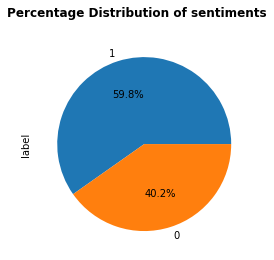

In [10]:
# label = data['label'].value_counts()
# print(label.plot.bar())

fig,ax1 = plt.subplots(1, 1, figsize=(8, 4))

pd.value_counts(df_news['label']).plot(kind = 'pie', ax=ax1,autopct='%1.1f%%')
plt.suptitle("Percentage Distribution of sentiments",fontweight = "bold")
plt.show()


On regarde si on a autant d'articles qui sont écrits par jour et par la suite voir par mois.
Par la suite, voir combien on en a de positives et de négatives par mois 

In [11]:
df_news.groupby('Date').size()
#print(date.plot.bar())

Date
2019-12-11    2
2019-12-12    8
2019-12-13    9
2019-12-16    5
2019-12-17    6
             ..
2020-04-22    3
2020-04-23    1
2020-04-27    2
2020-04-28    4
2020-04-29    1
Length: 92, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


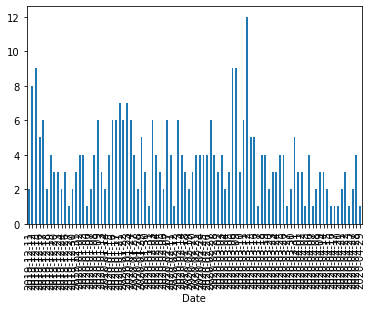

In [12]:
date = df_news.groupby('Date').size()
print(date.plot.bar())

In [13]:
def getYearMonth():
    data = new_dataset()
    data['Y_M'] = ""
    
    for i, x in data['Date'].iteritems():
        data['Y_M'].loc[i] = x.strftime('%Y-%m')
        
    return data

In [14]:
df_news = getYearMonth()

AxesSubplot(0.125,0.125;0.775x0.755)


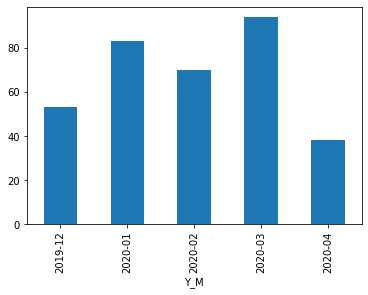

In [15]:
month = df_news.groupby('Y_M').size()
print(month.plot.bar())

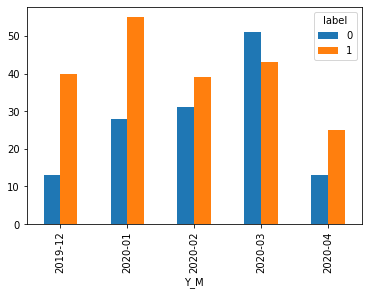

In [16]:
pd.crosstab(df_news['Y_M'],df_news['label']).plot.bar()

In [17]:
df_news

,article,Date,Open,Close,label,Y_M
0,Bourse : Réflexes naturels.Les investisseurs s...,2020-04-29,32.480000,31.23,1,2020-04
1,La dynamique des «exit techs» coupée dans son ...,2020-04-28,33.209999,33.57,0,2020-04
2,Coronavirus : ce qu'il faut retenir de la jour...,2020-04-28,33.209999,33.57,0,2020-04
3,Bourse/Gafam : Ce qui se raréfie peut être ché...,2020-04-28,33.209999,33.57,0,2020-04
4,150.000 particuliers ont fait leurs premiers p...,2020-04-28,33.209999,33.57,0,2020-04
...,...,...,...,...,...,...
333,Les propositions du patronat pour lutter contr...,2019-12-12,14.940000,13.94,1,2019-12
334,Volatilité/Bourse : L'envie de retour d'une gr...,2019-12-12,14.940000,13.94,1,2019-12
335,"Le vélo d'intérieur, le vendeur à découvert et...",2019-12-12,14.940000,13.94,1,2019-12
336,Sanofi : ordonnance royale.Quand le nouveau pl...,2019-12-11,15.570000,14.99,1,2019-12


On utilise une visualition assez parlante et claire afin de voir quels sont les mots qui apparaissent le plus dans notre dataset:
    - les mots les plus récurrents dans nos titres d'articles
    - les mots les plus récurrents dans nos introductions d'articles 

In [18]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

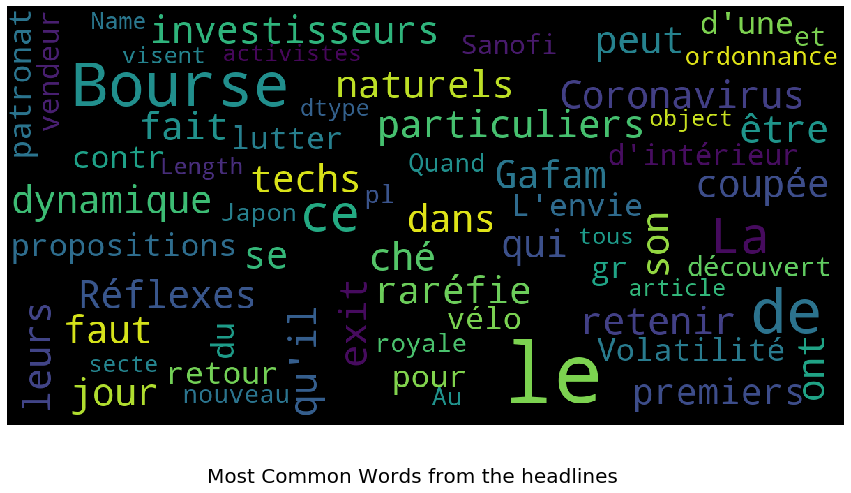

In [19]:
show_wordcloud(df_news['article'],'Most Common Words from the headlines')

On remarque que la plupart des mots présents dans notre corpus sont des mots trés présents dans la langue française:
    - pronom, conjontion de coordination , ...
    - Aussi la présence de même mot à cause de la ponctuation
On va donc essayer de les enlever afin d'avoir des mots plus parlants 

In [20]:
from nltk.corpus import stopwords

stop_words = stopwords.words('french')
print(stop_words)
df_news['article'] = df_news['article'].str.lower()

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

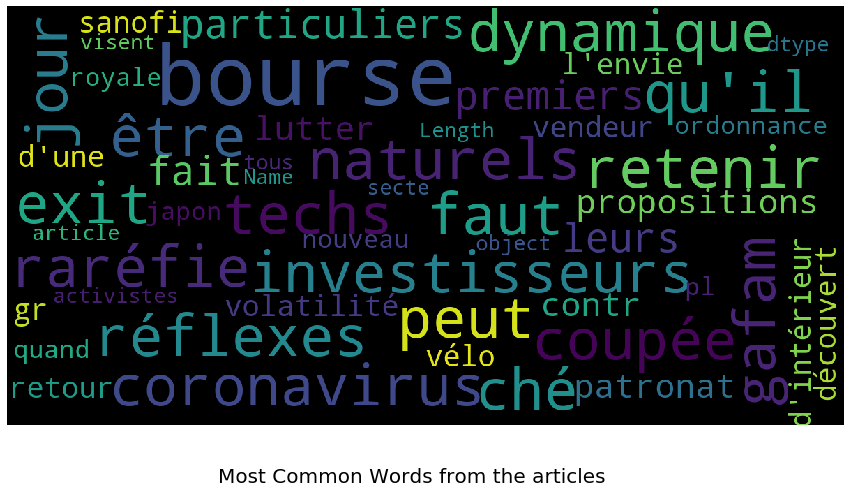

In [21]:
show_wordcloud(df_news['article'],'Most Common Words from the articles')

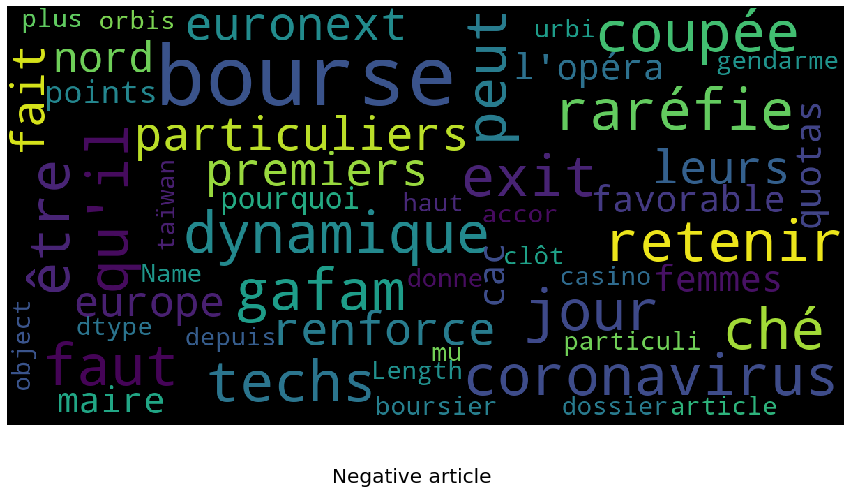

In [22]:
show_wordcloud(df_news[df_news['label'] == 0]['article'],'Negative article')

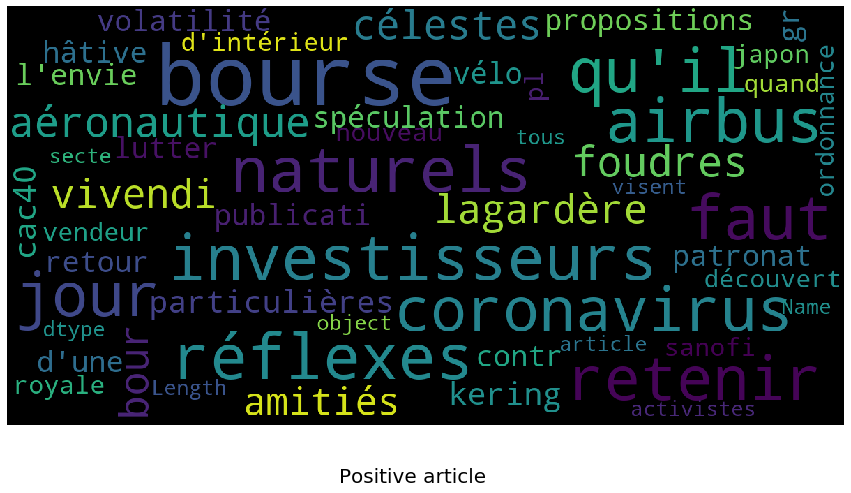

In [23]:
show_wordcloud(df_news[df_news['label'] == 1]['article'],'Positive article')

## Data Preprocessing

In [24]:
def data_cleaning(text):
    '''
    Tout mettre en minuscule, enlever les ponctuations et les chiffres
    <<< NB: NE PAS UTILISER SUR LA COLONNE DATE >>>
    '''
    text = text.lower()
    text = re.sub('\[.*?\']',' ',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),' ',text)
    text = re.sub('\w*\d\w*',' ',text)
    text = text.replace(u'\xa0', u' ')
    text = " ".join(text.split())

    return text

clean = lambda df: data_cleaning(df)

In [25]:
df_news['article'] = df_news['article'].apply(clean)

In [26]:
df_news

,article,Date,Open,Close,label,Y_M
0,bourse réflexes naturels les investisseurs son...,2020-04-29,32.480000,31.23,1,2020-04
1,la dynamique des «exit techs» coupée dans son ...,2020-04-28,33.209999,33.57,0,2020-04
2,coronavirus ce qu il faut retenir de la journé...,2020-04-28,33.209999,33.57,0,2020-04
3,bourse gafam ce qui se raréfie peut être chéri...,2020-04-28,33.209999,33.57,0,2020-04
4,particuliers ont fait leurs premiers pas en bo...,2020-04-28,33.209999,33.57,0,2020-04
...,...,...,...,...,...,...
333,les propositions du patronat pour lutter contr...,2019-12-12,14.940000,13.94,1,2019-12
334,volatilité bourse l envie de retour d une gran...,2019-12-12,14.940000,13.94,1,2019-12
335,le vélo d intérieur le vendeur à découvert et ...,2019-12-12,14.940000,13.94,1,2019-12
336,sanofi ordonnance royale quand le nouveau plan...,2019-12-11,15.570000,14.99,1,2019-12


In [27]:
df_news['article'].loc[5]

'coronavirus ce qu il faut retenir de la journée du avril la france a enregistré lundi décès supplémentaires en heures portant le bilan total de l épidémie à morts edouard philippe présentera mardi le plan de déconfinement alors que le chômage bondit et que plus d un parent sur deux ne souhaite pas renvoyer son enfant à l école'

In [28]:
def data_model():
    
    data = getYearMonth()
    data['article'] = data['article'].str.lower()
    data['article'] = data['article'].apply(clean)
    
    data = data[['Date', 'article', 'label']]
    date = pd.unique(data['Date']).tolist()
    rows= []
    data['Y'] = ""
        
    for i in date:
        df = data[data['Date'] == i]
        text = pd.unique(df['article']).tolist()
        sentiment = pd.unique(df['label']).tolist()
        rows.append([i,text,sentiment])
        
    df_article = pd.DataFrame(rows, columns = ['date', 'article', 'label'])
    
    
    ##pour pouvoir traiter le text, on doit l'avoir sous format list of list 
    for i,j in enumerate(df_article['article']):
        df_article['article'].loc[i] = [[a] for a in j]
    
    df_article['Y'] = [item for sublist in df_article['label'] for item in sublist]

    return df_article

In [29]:
final_df = data_model()

In [30]:
final_df

,date,article,label,Y
0,2020-04-29,[[bourse réflexes naturels les investisseurs s...,[1],1
1,2020-04-28,[[la dynamique des «exit techs» coupée dans so...,[0],0
2,2020-04-27,[[coronavirus ce qu il faut retenir de la jour...,[1],1
3,2020-04-23,[[euronext se renforce en europe du nord l opé...,[0],0
4,2020-04-22,[[lagardère vivendi amitiés particulières la s...,[1],1
...,...,...,...,...
87,2019-12-17,[[placements chasse à la bonne raison l évolut...,[0],0
88,2019-12-16,[[le cac au dessus des points pour la première...,[1],1
89,2019-12-13,[[trump et johnson rassurent les bourses asiat...,[1],1
90,2019-12-12,[[les banques impliquées dans le plus grand sc...,[1],1


In [31]:
final_df['article'].loc[1]

[['la dynamique des «exit techs» coupée dans son élan le nombre de rachats ou d introductions en bourse de valeurs technologiques françaises avait connu un pic au début de l année face à la crise du coronavirus le flux des transactions est stoppé net'],
 ['coronavirus ce qu il faut retenir de la journée du avril sans surprise les députés ont validé le plan de déconfinement du gouvernement lors d un vote consultatif après cinq heures de débat au total cas graves sont toujours traités dans les services de réanimation français soit patients en moins le nombre d hospitalisation est aussi en baisse au cours des dernières heures personnes sont décédées du nouveau coronavirus'],
 ['bourse gafam ce qui se raréfie peut être chéri la croissance saine financièrement restera une denrée rare'],
 ['particuliers ont fait leurs premiers pas en bourse depuis deux mois les particuliers ont cherché les bonnes affaires au plus fort de la tempête boursière entre fin février et début avril investisseurs par

## MODEL LSTM 

On aimerait connaitres les stats descriptives concernant nos articles:
    - nombre minimum d'article par jour
    - nombre maximal d'article par jour
    - mediam 
    - etc ... 
    -Aussi, faire la meme analyse par nombres de mots des articles
Ceci nous permettra pour le pad_sequence

In [32]:
taille = []
for i in final_df['article']:
    taille.append(len(i))
print("le nombre d'article minimal est de ",np.min(taille))
print("le premier quantil est de ",np.quantile(taille, q=0.25))
print("le nombre d'article médian est de ",np.median(taille))
print("le nombre d'article moyen est de ",np.mean(taille))
print("le troisiéme quantile est de ",np.quantile(taille, q=0.75))
print("le nombre d'article maximal est de ",np.max(taille))

le nombre d'article minimal est de  1
le premier quantil est de  2.0
le nombre d'article médian est de  3.0
le nombre d'article moyen est de  3.6739130434782608
le troisiéme quantile est de  4.25
le nombre d'article maximal est de  12


In [33]:
slen = []
for i in final_df['article']:
    for j in i:
        slen.append([len(s.split()) for s in j])

print("le nombre de mot minimal est de ",np.min(slen))
print("le premier quantil est de ",np.quantile(slen, q=0.25))
print("le nombre médian est de ",np.quantile(slen, q=0.5))
print("le nombre de mot moyen est de ",np.mean(slen))
print("le troisième quartile est de ",np.quantile(slen, q=0.75))
print("le nombre de mot maximal est de ",np.max(slen))


le nombre de mot minimal est de  13
le premier quantil est de  38.25
le nombre médian est de  49.0
le nombre de mot moyen est de  46.97337278106509
le troisième quartile est de  58.0
le nombre de mot maximal est de  85


In [34]:
data = final_df

In [35]:
data

,date,article,label,Y
0,2020-04-29,[[bourse réflexes naturels les investisseurs s...,[1],1
1,2020-04-28,[[la dynamique des «exit techs» coupée dans so...,[0],0
2,2020-04-27,[[coronavirus ce qu il faut retenir de la jour...,[1],1
3,2020-04-23,[[euronext se renforce en europe du nord l opé...,[0],0
4,2020-04-22,[[lagardère vivendi amitiés particulières la s...,[1],1
...,...,...,...,...
87,2019-12-17,[[placements chasse à la bonne raison l évolut...,[0],0
88,2019-12-16,[[le cac au dessus des points pour la première...,[1],1
89,2019-12-13,[[trump et johnson rassurent les bourses asiat...,[1],1
90,2019-12-12,[[les banques impliquées dans le plus grand sc...,[1],1


In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def model_lstm():
    
    #data = data_model()
    tknz = Tokenizer()
    max_length = 60
    max_article = 6
    shape = data.shape[0]

    X = data['article']
    Y = data['Y'].astype(np.float32)
    Y = np.asarray(Y)

    tok_data = [y[0] for x in X for y in x]
    tknz.fit_on_texts(tok_data)
    
    Z = data['article']
    Z = np.zeros((shape, max_article, max_length)).astype(np.float32)

    for j,i in enumerate(X):
        tmp = []
        for y in i:
            tmp.append(tknz.texts_to_sequences(y)[0])
            pad_seq = pad_sequences(sequences = tmp, maxlen = max_length, dtype = 'float32', padding = 'post', truncating = 'post')
            t = min(max_article, pad_seq.shape[0])
            pad_seq = pad_seq[:t]
            a = max_article - t
            Z[j][a:] = pad_seq
            #data['X'].loc[j] = Z[j][:]
    Z = Z.astype(np.float32)
    vocab_size = len(tknz.word_index)+1
    
    
    embeddings_dictionary = dict()

    glove_file = open('multilingual_embeddings.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, 300))
    for word, index in tknz.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    #train et test data
    X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size=0.3, random_state=42)
    
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length = max_length))
    model.add(Dropout(0.25))
    model.add(LSTM(256))
    model.add(Dense(64))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    print(model.summary())    
    #plot the model
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.1, batch_size = 64)
    
    plt.clf()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'y', label='Test loss')
    plt.title('Training and test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'y', label='Test acc')
    plt.title('Training and test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    #let's evaluate our test data
    score = model.evaluate(X_test, y_test, verbose=1)

    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    
#     ypred=model.predict(X_test)

#     ypred[ypred>0.5]=1 
#     ypred[ypred<=0.5]=0 
#     cm = confusion_matrix(y_test, ypred)
#     print(cm)
    
#     y_pred_test = model.predict_classes(X_test)
#     print(y_pred_test)

    p_train = model.predict(X_train)
    p_test = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, np.argmax(p_train, axis=1))
    test_acc = accuracy_score(y_test, np.argmax(p_test, axis=1))
    
    # Confusion matrix
    train_cmat = confusion_matrix(y_train, np.argmax(p_train, axis=1))
    test_cmat = confusion_matrix(y_test, np.argmax(p_test, axis=1))
    
    # Perf
    print("Confusion train\n", train_cmat)
    print("Confusion test\n", test_cmat)
    print("Acc train\n", train_acc)
    print("Acc test\n", test_acc)

In [39]:
model_lstm()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 300)           1048200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,635,081
Trainable params: 1,635,081
Non-trainable params: 0
____________________________________________

ValueError: Error when checking input: expected embedding_1_input to have 2 dimensions, but got array with shape (64, 6, 60)